<a href="https://colab.research.google.com/github/RuiaRui/project_CSM/blob/main/CSM_ML_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline

In [ ]:
! pip install bertopic
! pip install pynndescent==0.5
# need restart run this first

In [35]:
import bz2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm.notebook import tqdm
import dill
import csv

### Load Data

In [36]:
# path_4 = r'/content/drive/MyDrive/CSM_Project/april_en_refugee_clean.pkl'
# path_23 = r'/content/drive/MyDrive/CSM_Project/feb_march_refugee_clean.pkl'
path=f'/content/drive/MyDrive/CSM_Project/full_data.json.bz2'


In [37]:
df_full=pd.read_json(path)

In [38]:
df_full.reset_index(inplace=True)
df_full.drop(df_full.columns[df_full.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_full.drop('index',axis = 1, inplace = True)
# df_full['tweetcreatedts']=df_full.tweetcreatedts.apply(pd.to_datetime)

In [39]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47394 entries, 0 to 47393
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   userid                   47394 non-null  int64  
 1   username                 47394 non-null  object 
 2   acctdesc                 43295 non-null  object 
 3   location                 34675 non-null  object 
 4   following                47394 non-null  int64  
 5   followers                47394 non-null  int64  
 6   totaltweets              47394 non-null  int64  
 7   usercreatedts            47394 non-null  object 
 8   tweetid                  47394 non-null  int64  
 9   tweetcreatedts           47394 non-null  object 
 10  retweetcount             47394 non-null  int64  
 11  text                     47394 non-null  object 
 12  hashtags                 47394 non-null  object 
 13  language                 47394 non-null  object 
 14  coordinates           

In [40]:
df_full.text.head(5).apply(print)

It s not hard for both  ScottMorrisonMP and  AlboMP to agree that Australia must  Qantas charter flights to extract #refugees that will be pouring into Poland, Slovakia, Hungary and Romania from #Ukraine #auspol #ausvotes #Russia #UkraineCrisis URL
SO FAR #PUTIN HAS TERRORISED THE FOLLOWING UKRAINIAN CITIES Kyiv Odesa Kharkiv Mykolai Mariupol  #Ukraine reports over 100  casualties and the US estimates over 100,00 civilian casualties will take place plus millions of refugees.  #STOPTHEWAR #PRAYFORPEACE
Frankly  ScottMorrisonMP and  AlboMP should agree to charter  Qantas flights to extract Australians in Eastern Europe and any Ukrainian refugee fleeing #auspol #ausvotes #Russian #Ukraine #RussiaUkraine URL
Full scale invasion of #Ukraine now underway We need to help them in any way we can including taking in all refugees.  Much will change in Europe. There will be consequences. It s a dark day!
To watch Morrison pretend to care about the people of #Ukraine and offer asylum to refugees fr

0    None
1    None
2    None
3    None
4    None
Name: text, dtype: object

## Sentimental Analysis - ROBERTa-twitter

In [ ]:
! pip install transformers
! pip install sentencepiece

In [41]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import urllib.request
from scipy.special import softmax

In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)


Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [ ]:
model = model.to(device)

In [ ]:
tensors = []
for tweet in tqdm(df_full.text):
    encoded_input = tokenizer(tweet, return_tensors='pt').to("cuda:0")
    output = model(**encoded_input)
    tensors.append(output[0][0].detach())

  0%|          | 0/47394 [00:00<?, ?it/s]

In [ ]:
tweets_scores = []
for t in tensors:
    scores = t.cpu().numpy()
    scores = softmax(scores)
    tweets_scores.append(scores)

In [ ]:
df_full['score']=tweets_scores

In [ ]:
df_full['negative_sentiment'] = [x[0] for x in df_full['score']]
df_full['neutral_sentiment'] = [x[1] for x in df_full['score']]
df_full['positive_sentiment'] = [x[2] for x in df_full['score']]
df_full['max_sentiment'] = [labels[np.argmax(x)] for x in df_full['score']]


In [ ]:
df_full[['tweetid','text','score','max_sentiment']].head(10)

,tweetid,text,score,max_sentiment
0,1496738740424876035,It s not hard for both ScottMorrisonMP and A...,"[0.17855391, 0.7132651, 0.10818093]",neutral
1,1496738774277148674,SO FAR #PUTIN HAS TERRORISED THE FOLLOWING UKR...,"[0.8589728, 0.13434762, 0.006679563]",negative
2,1496738799845404678,Frankly ScottMorrisonMP and AlboMP should ag...,"[0.21800964, 0.7297994, 0.05219093]",neutral
3,1496743349683994625,Full scale invasion of #Ukraine now underway W...,"[0.5783562, 0.36306685, 0.058576964]",negative
4,1496743392386109445,To watch Morrison pretend to care about the pe...,"[0.94848317, 0.049137287, 0.0023795976]",negative
5,1496747031427227650,It is war that creates refugees It is war tha...,"[0.78962886, 0.19674861, 0.013622586]",negative
6,1496751045162242051,Tell your politicians whereever you are that y...,"[0.3048881, 0.5902976, 0.10481442]",neutral
7,1496755698172313602,How it started #refugee border crisis between...,"[0.75961024, 0.22795847, 0.012431257]",negative
8,1496755737476878337,"Explosions in Kiev, Russian and Belarusian tr...","[0.80178124, 0.18503153, 0.01318704]",negative
9,1496756196589592576,"VitalikButerin IOHK Charles Vitalik, Charles...","[0.30310383, 0.60507935, 0.091816805]",neutral


In [ ]:
df_full[['tweetid','text','score','max_sentiment']].to_json('/content/drive/MyDrive/CSM_Project/data_2t4_sentiment.json.bz2')

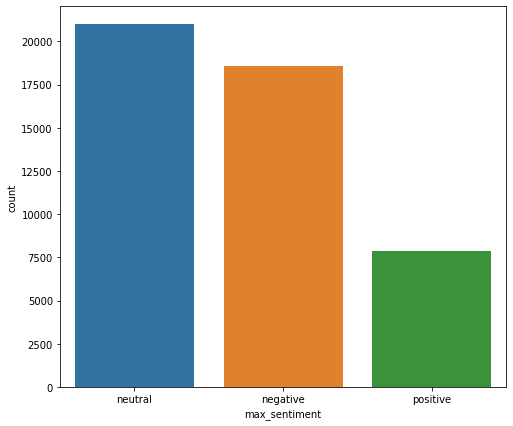

In [ ]:
plt.figure(figsize = (8,7))
sns.countplot(x="max_sentiment", data=df_full.drop_duplicates(subset=['text']))

In [ ]:
df_full.text.loc[328]

'As a #Syrian I don t feel I should only stand in #solidarity with #Ukraine against the #Russia n barbarian #invasion . I think we should work actively and tiredly to #support the #Ukranian refugees and activists especially that we know what they need the most. We have been there.'

In [ ]:
df_full.max_sentiment.loc[328]

'neutral'

In [ ]:
for t in df_full[df_full['max_sentiment']=='negative'].text.head(10):
  print(t)
  print('\n')

SO FAR #PUTIN HAS TERRORISED THE FOLLOWING UKRAINIAN CITIES Kyiv Odesa Kharkiv Mykolai Mariupol  #Ukraine reports over 100  casualties and the US estimates over 100,00 civilian casualties will take place plus millions of refugees.  #STOPTHEWAR #PRAYFORPEACE


Full scale invasion of #Ukraine now underway We need to help them in any way we can including taking in all refugees.  Much will change in Europe. There will be consequences. It s a dark day!


To watch Morrison pretend to care about the people of #Ukraine and offer asylum to refugees from there while he jails for nearly a decade refugees who are victims of the same kind of wars in places like Afghanistan, Syria, Iraq, Somalia, Myanmar and Sri Lanka is just too much to bear


It is war that creates refugees  It is war that creates refugees  You can t be against war but then refuse to protect and take refugees  It is swift action that is needed not just for the people of #Ukraine but for refugees who are victims of war around the w

In [ ]:
df_full.to_json('/content/drive/MyDrive/0401_UkraineCombinedTweetsDeduped_SA_BERT.json.bz2')

## BERTopic

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=100, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True, 
                        min_samples=5)

vectorizer_model = CountVectorizer(ngram_range=(1, 2), 
                                   stop_words="english", 
                                   min_df=10, 
                                   max_df=0.95)

In [86]:
from bertopic import BERTopic

topic_model = BERTopic(verbose=True,
                 embedding_model='all-mpnet-base-v2', 
                 vectorizer_model=vectorizer_model,
                 hdbscan_model=hdbscan_model,
                 calculate_probabilities=False,
                 min_topic_size=100,
                 nr_topics="auto")

In [87]:
topics, probs = topic_model.fit_transform(df_full.text)

Batches:   0%|          | 0/1482 [00:00<?, ?it/s]

2022-05-20 12:55:41,320 - BERTopic - Transformed documents to Embeddings
2022-05-20 12:56:21,661 - BERTopic - Reduced dimensionality
2022-05-20 12:56:25,767 - BERTopic - Clustered reduced embeddings
2022-05-20 12:56:33,948 - BERTopic - Reduced number of topics from 74 to 53


In [88]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,17793,-1_aid_humanitarian_children_url ukraine
1,0,5425,0_poland_moldova_polish_border
2,1,4487,1_uk_government_borisjohnson_canada
3,2,1736,2_million_fled_fled ukraine_million people
4,3,1651,3_racism_white_black_african
5,4,1123,4_donations_donate_art_proceeds
6,5,1098,5_biden_president_illegal_administration
7,6,925,6_mariupol_azov_city_refugees mariupol
8,7,666,7_civilians_million_millions_syria
9,8,618,8_podcast_listen_refugee crisis_join


In [89]:
topic_model.visualize_topics()

In [96]:
fig = topic_model.visualize_barchart(top_n_topics=20)
fig.write_html("/content/drive/MyDrive/CSM_Project/topic_word_score.html")
fig

In [91]:
topic_model.save('/content/drive/MyDrive/CSM_Project/bert_topic_model')

In [92]:
timestamps=df_full.tweetcreatedts.apply(pd.to_datetime).dt.date

In [93]:
topics_over_time = topic_model.topics_over_time(df_full.text,topics,timestamps)


58it [00:07,  7.25it/s]


In [97]:

fig = topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)
fig.write_html("/content/drive/MyDrive/CSM_Project/topic_over_time.html")
fig

In [98]:
df_full['topics']=topics
df_full.head(5)

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,topics
0,129788409,mansillo,"Elections, public opinion & social science sta...","Sydney, New South Wales",2335,4357,23873,2010-04-05 11:56:39.000000,1496738740424876035,2022-02-24 06:48:18.000000,...,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,-1
1,20401011,beth001,"Passions: Judaism, teaching, politics, beaches...","Buffalo, NY",1752,417,10805,2009-02-08 23:22:06.000000,1496738774277148674,2022-02-24 06:48:26.000000,...,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,7
2,23925452,Gregarious21,🇦🇺🇺🇦,Canberra,507,156,2929,2009-03-12 09:37:01.000000,1496738799845404678,2022-02-24 06:48:32.000000,...,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,-1
3,1298280700391706624,1015_cookie,25 years as a bartender a.k.a. a therapist,None,5888,5407,200263,2020-08-25 15:27:23.000000,1496743349683994625,2022-02-24 07:06:37.000000,...,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,32
4,1463802686499811333,quadros_kati,None,None,34,30,3290,2021-11-25 09:35:37.000000,1496743392386109445,2022-02-24 07:06:47.000000,...,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,-1
